# Install

In [ ]:
#pip install --upgrade jaxlib
!pip install jaxlib==0.4.23
!pip install jax==0.4.23

In [ ]:
pip install --upgrade e3nn-jax

In [ ]:
pip install --upgrade jax-md

In [ ]:
pip install sympy

In [ ]:
pip install scikit-image

In [ ]:
import jax
print(jax.__version__)


In [ ]:
!pip list | grep jax


e3nn-jax            0.20.7
jax                 0.4.30
jax-md              0.2.8
jaxlib              0.4.30


In [ ]:
import jax.numpy as np

ModuleNotFoundError: No module named 'jax'

#Revised

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, grad, random, jacfwd, jacrev
from functools import partial
from jax_md import space, quantity
from jax.config import config
config.update('jax_enable_x64', True)
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

/var/folders/0z/gf4916fj1db5y97y6tvmn0lr0000gn/T/ipykernel_13304/83870980.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [ ]:
displacement, shift = space.free()
metric = space.metric(displacement)
# displacement = space.map_product(displacement)
# metric = space.map_product(metric)

In [ ]:
alpha = 25
eta_1, eta_2 = 1e-2, 1e-8
N, dim = 500, 2
D_R, D_C = 0.01, 0.001
t0, t1, dt = 0, 0.5, 0.001

In [ ]:
key = random.PRNGKey(0)
box_size = quantity.box_size_at_number_density(particle_count=N, number_density=N/10, spatial_dimension=dim)
R0 = random.uniform(key, (N, dim), maxval=box_size)
C0 = random.uniform(key, (N, 3), minval=0.0, maxval=1.0)

In [ ]:
@jit
def C_field(R, C, x):
    metric_vmap = vmap(vmap(metric, in_axes=(None, 0)), in_axes=(0, None))
    distances = metric_vmap(jnp.array([x]), R)
    weights = jnp.exp(-alpha * jnp.square(distances))
    return jnp.einsum('ij,jk->k', weights, C)

batch_C_field = jit(vmap(C_field, in_axes=(None, None, 0)))

In [ ]:
@jit
def boundedness(R):
    center = jnp.array([box_size/2, box_size/2])
    distances = jnp.sum((R - center)**2, axis=1)
    return 1e-1 * jnp.sum(jax.nn.relu(distances - (box_size/8)**2))

In [ ]:
K2 = random.normal(random.PRNGKey(10), (3,3,3))

In [ ]:
@jit
def reaction(R, C):
    return jnp.einsum('ijk,pj,pk->pi', K2**2, C, C)

In [ ]:
@jit
def step(R, C, key):
    R_new = R - dt * grad(boundedness)(R) + jnp.sqrt(2*D_R*dt) * random.normal(key, R.shape)
    C_new = jnp.minimum(jnp.maximum(C + dt * reaction(R, C), 0.0), 1.0)
    return R_new, C_new

In [ ]:
@partial(jit, static_argnums=(2,))
def simulate(R0, C0, steps):
    def body_fun(carry, _):
        R, C, key = carry
        key, subkey = random.split(key)
        R_new, C_new = step(R, C, subkey)
        return (R_new, C_new, key), (R_new, C_new)

    init_key = random.PRNGKey(0)  # Use a fixed initial key
    _, (R_list, C_list) = jax.lax.scan(body_fun, (R0, C0, init_key), jnp.arange(steps))
    return R_list, C_list

In [ ]:
steps = int((t1-t0)/dt)
R_list, C_list = simulate(R0, C0, steps)

In [ ]:
@jit
def C_target(pos):
    pos_0_R = jnp.array([[box_size/2-box_size/3, box_size/2-box_size/3]])
    pos_0_G = jnp.array([[box_size/2, box_size/2+box_size/3]])
    pos_0_B = jnp.array([[box_size/2+box_size/3, box_size/2-box_size/3]])
    sig_R = sig_G = sig_B = 0.5
    return jnp.array([
        jnp.exp(-jnp.square(jnp.linalg.norm(pos-pos_0_R)/(2*sig_R**2))),
        jnp.exp(-jnp.square(jnp.linalg.norm(pos-pos_0_G)/(2*sig_G**2))),
        jnp.exp(-jnp.square(jnp.linalg.norm(pos-pos_0_B)/(2*sig_B**2)))
    ])

batch_C_target = jit(vmap(C_target))

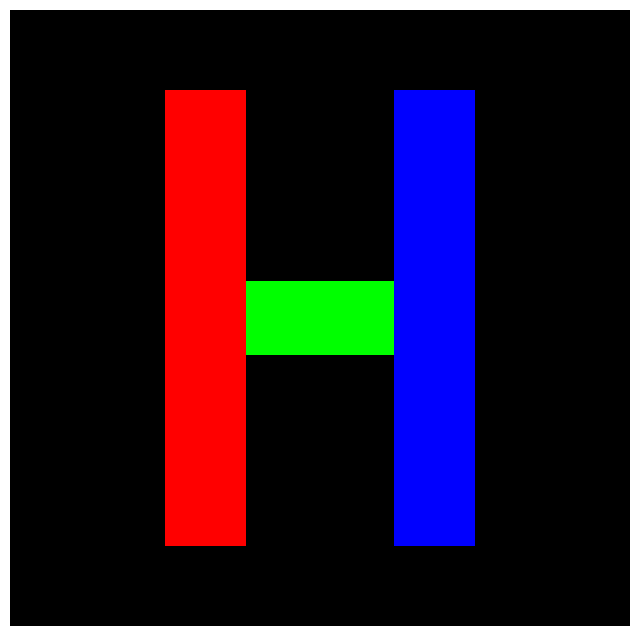

<Figure size 640x480 with 0 Axes>

In [ ]:
import jax.numpy as jnp
from jax import jit, vmap

@jit
def C_target(pos):
    # Define the dimensions of the H
    vertical_bar_width = box_size / 8
    horizontal_bar_height = box_size / 8
    h_height = box_size * 3 / 4

    # Define the positions of the H components
    left_x = box_size * 5 / 16
    right_x = box_size * 11 / 16
    top_y = box_size * 7 / 8
    bottom_y = box_size / 8
    middle_y = box_size / 2

    # Check if the position is within the left vertical bar (red)
    left_bar = (pos[0] >= left_x - vertical_bar_width/2) & (pos[0] <= left_x + vertical_bar_width/2) & \
               (pos[1] >= bottom_y) & (pos[1] <= top_y)

    # Check if the position is within the right vertical bar (blue)
    right_bar = (pos[0] >= right_x - vertical_bar_width/2) & (pos[0] <= right_x + vertical_bar_width/2) & \
                (pos[1] >= bottom_y) & (pos[1] <= top_y)

    # Check if the position is within the horizontal bar (green)
    horiz_bar = (pos[0] >= left_x + vertical_bar_width/2) & (pos[0] <= right_x - vertical_bar_width/2) & \
                (pos[1] >= middle_y - horizontal_bar_height/2) & (pos[1] <= middle_y + horizontal_bar_height/2)

    # Add some smoothing to the edges
    sigma = box_size / 100  # Adjust this value to change the amount of smoothing
    red = jnp.exp(-((pos[0] - left_x)**2 + (pos[1] - middle_y)**2) / (2*sigma**2)) * left_bar
    green = jnp.exp(-((pos[0] - (left_x + right_x)/2)**2 + (pos[1] - middle_y)**2) / (2*sigma**2)) * horiz_bar
    blue = jnp.exp(-((pos[0] - right_x)**2 + (pos[1] - middle_y)**2) / (2*sigma**2)) * right_bar

    # Normalize colors to ensure they sum to 1 at each point
    total = red + green + blue
    total = jnp.where(total == 0, 1.0, total)  # Replace zero totals with 1 to avoid division by zero
    red, green, blue = red / total, green / total, blue / total

    return jnp.array([red, green, blue])

batch_C_target = jit(vmap(C_target))

n = 100
x = jnp.linspace(0, box_size, n)
y = jnp.linspace(0, box_size, n)
X, Y = jnp.meshgrid(x, y)
positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

C_target_eval = batch_C_target(positions)
C_target_image = C_target_eval.reshape(n, n, 3)

plt.figure(figsize=(8, 8))
# plt.imshow(C_target_image)
plt.pcolormesh(X, Y, C_target_image)
plt.axis('off')
# plt.title('H-shaped Target Field')
plt.show()
plt.savefig('target_pattern' + '.pdf', bbox_inches='tight')

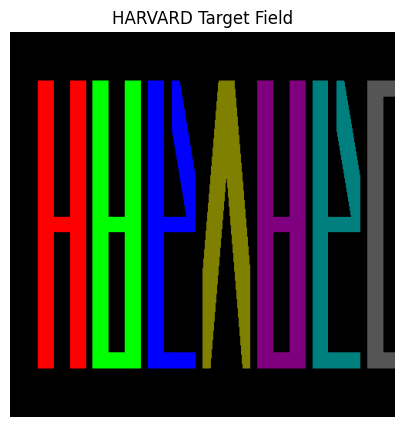

In [ ]:
import jax.numpy as jnp
from jax import jit, vmap
import matplotlib.pyplot as plt

@jit
def letter_H(pos, left_x, width):
    vertical_bar_width = width / 3
    horizontal_bar_height = width / 3
    h_height = width * 3 / 4

    right_x = left_x + width
    top_y = box_size * 1 / 8  # Flipped
    bottom_y = box_size * 7 / 8  # Flipped
    middle_y = box_size / 2

    left_bar = (pos[0] >= left_x) & (pos[0] <= left_x + vertical_bar_width) & \
               (pos[1] >= top_y) & (pos[1] <= bottom_y)
    right_bar = (pos[0] >= right_x - vertical_bar_width) & (pos[0] <= right_x) & \
                (pos[1] >= top_y) & (pos[1] <= bottom_y)
    horiz_bar = (pos[0] >= left_x) & (pos[0] <= right_x) & \
                (pos[1] >= middle_y - horizontal_bar_height/2) & (pos[1] <= middle_y + horizontal_bar_height/2)

    return left_bar | right_bar | horiz_bar

@jit
def letter_A(pos, left_x, width):
    bar_width = width / 3
    top_y = box_size * 1 / 8  # Flipped
    bottom_y = box_size * 7 / 8  # Flipped
    middle_y = box_size / 2

    left_bar = (pos[0] >= left_x) & (pos[0] <= left_x + bar_width) & \
               (pos[1] >= top_y) & (pos[1] <= bottom_y)
    right_bar = (pos[0] >= left_x + width - bar_width) & (pos[0] <= left_x + width) & \
                (pos[1] >= top_y) & (pos[1] <= bottom_y)
    top_bar = (pos[0] >= left_x) & (pos[0] <= left_x + width) & \
              (pos[1] >= top_y) & (pos[1] <= top_y + bar_width)
    middle_bar = (pos[0] >= left_x) & (pos[0] <= left_x + width) & \
                 (pos[1] >= middle_y - bar_width/2) & (pos[1] <= middle_y + bar_width/2)

    return left_bar | right_bar | top_bar | middle_bar

@jit
def letter_R(pos, left_x, width):
    bar_width = width / 3
    top_y = box_size * 1 / 8  # Flipped
    bottom_y = box_size * 7 / 8  # Flipped
    middle_y = (top_y + bottom_y) / 2

    left_bar = (pos[0] >= left_x) & (pos[0] <= left_x + bar_width) & \
               (pos[1] >= top_y) & (pos[1] <= bottom_y)
    top_bar = (pos[0] >= left_x) & (pos[0] <= left_x + width) & \
              (pos[1] >= top_y) & (pos[1] <= top_y + bar_width)
    middle_bar = (pos[0] >= left_x) & (pos[0] <= left_x + width) & \
                 (pos[1] >= middle_y - bar_width/2) & (pos[1] <= middle_y + bar_width/2)
    diagonal = (pos[0] >= left_x + width/2) & (pos[0] <= left_x + width) & \
               (pos[1] >= middle_y) & (pos[1] <= bottom_y) & \
               (pos[0] - (left_x + width/2) >= (bottom_y - pos[1]) * (width/2) / (bottom_y - middle_y) - bar_width/2) & \
               (pos[0] - (left_x + width/2) <= (bottom_y - pos[1]) * (width/2) / (bottom_y - middle_y) + bar_width/2)

    return left_bar | top_bar | middle_bar | diagonal

@jit
def letter_V(pos, left_x, width):
    bar_width = width / 3
    top_y = box_size * 1 / 8  # Flipped
    bottom_y = box_size * 7 / 8  # Flipped

    left_diagonal = (pos[0] >= left_x) & (pos[0] <= left_x + width/2) & \
                    (pos[1] >= top_y) & (pos[1] <= bottom_y) & \
                    (pos[0] - left_x >= (pos[1] - top_y) * (width/2) / (bottom_y - top_y) - bar_width/2) & \
                    (pos[0] - left_x <= (pos[1] - top_y) * (width/2) / (bottom_y - top_y) + bar_width/2)
    right_diagonal = (pos[0] >= left_x + width/2) & (pos[0] <= left_x + width) & \
                     (pos[1] >= top_y) & (pos[1] <= bottom_y) & \
                     (pos[0] - (left_x + width/2) <= (bottom_y - pos[1]) * (width/2) / (bottom_y - top_y) + bar_width/2) & \
                     (pos[0] - (left_x + width/2) >= (bottom_y - pos[1]) * (width/2) / (bottom_y - top_y) - bar_width/2)

    return left_diagonal | right_diagonal

@jit
def letter_D(pos, left_x, width):
    bar_width = width / 3
    top_y = box_size * 1 / 8  # Flipped
    bottom_y = box_size * 7 / 8  # Flipped

    left_bar = (pos[0] >= left_x) & (pos[0] <= left_x + bar_width) & \
               (pos[1] >= top_y) & (pos[1] <= bottom_y)
    top_bar = (pos[0] >= left_x) & (pos[0] <= left_x + width) & \
              (pos[1] >= top_y) & (pos[1] <= top_y + bar_width)
    bottom_bar = (pos[0] >= left_x) & (pos[0] <= left_x + width) & \
                 (pos[1] >= bottom_y - bar_width) & (pos[1] <= bottom_y)
    right_curve = (pos[0] >= left_x + width - bar_width) & (pos[0] <= left_x + width) & \
                  (pos[1] >= top_y) & (pos[1] <= bottom_y) & \
                  ((pos[0] - (left_x + width - bar_width))**2 + (pos[1] - (top_y + bottom_y)/2)**2 <= (width/2)**2) & \
                  ((pos[0] - (left_x + width - bar_width))**2 + (pos[1] - (top_y + bottom_y)/2)**2 >= (width/2 - bar_width)**2)

    return left_bar | top_bar | bottom_bar | right_curve

@jit
def C_target(pos):
    letter_width = box_size / 8
    spacing = box_size / 56
    start_x = box_size / 14

    h1 = letter_H(pos, start_x, letter_width)
    a = letter_A(pos, start_x + letter_width + spacing, letter_width)
    r = letter_R(pos, start_x + 2 * (letter_width + spacing), letter_width)
    v = letter_V(pos, start_x + 3 * (letter_width + spacing), letter_width)
    a2 = letter_A(pos, start_x + 4 * (letter_width + spacing), letter_width)
    r2 = letter_R(pos, start_x + 5 * (letter_width + spacing), letter_width)
    d = letter_D(pos, start_x + 6 * (letter_width + spacing), letter_width)

    letters = jnp.array([h1, a, r, v, a2, r2, d])
    colors = jnp.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1], [0.5, 0.5, 0.5]])

    result = jnp.zeros(3)
    for i in range(7):
        result += jnp.where(letters[i], colors[i], 0)

    # Normalize colors
    total = jnp.sum(result)
    result = jnp.where(total > 0, result / total, 0)

    return result

batch_C_target = jit(vmap(C_target))

# Generate the target image
n = 500  # Increased resolution for better quality
x = jnp.linspace(0, box_size, n)
y = jnp.linspace(0, box_size, n)
X, Y = jnp.meshgrid(x, y)
positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

C_target_eval = batch_C_target(positions)
C_target_image = C_target_eval.reshape(n, n, 3)

# Plot the target image
plt.figure(figsize=(15, 5))
plt.imshow(C_target_image[::-1, :, :])  # Flip the image vertically
plt.axis('off')
plt.title('HARVARD Target Field')
plt.show()

In [ ]:
@jit
def terminal_cost_L2(R, C):
    n = 100
    x = jnp.linspace(0, box_size, n)
    y = jnp.linspace(0, box_size, n)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

    C_eval = batch_C_field(R, C, positions)
    C_target_eval = batch_C_target(positions)

    center = jnp.array([box_size/2, box_size/2])

    return jnp.sum(jnp.square(C_eval - C_target_eval)) + 0.01*jnp.sum(jax.nn.relu(jnp.sum((R - center)**2, axis=1) - box_size**2)*jnp.sum(jnp.square(C), axis=1))

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit, vmap

@jit
def sinkhorn_distance(a, b, M, eps=0.01, max_iter=100):
    """
    Compute Sinkhorn distance between two distributions
    a, b: 1D arrays representing the two distributions
    M: cost matrix
    eps: regularization parameter
    max_iter: maximum number of iterations
    """
    K = jnp.exp(-M / eps)

    def step(carry, _):
        u, v = carry
        u = a / (K @ v)
        v = b / (K.T @ u)
        return (u, v), None

    u = jnp.ones_like(a)
    v = jnp.ones_like(b)
    (u, v), _ = jax.lax.scan(step, (u, v), None, length=max_iter)

    return jnp.sum(u * (K @ v) * M)

@jit
def terminal_cost(R, C):
    n = 10
    x = jnp.linspace(0, box_size, n)
    y = jnp.linspace(0, box_size, n)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

    C_eval = batch_C_field(R, C, positions)
    C_target_eval = batch_C_target(positions)

    # Reshape to (n*n, 3) for easier handling
    C_eval = C_eval.reshape(-1, 3)
    C_target_eval = C_target_eval.reshape(-1, 3)

    # Normalize distributions for each color channel
    C_eval_norm = C_eval / jnp.sum(C_eval, axis=0)
    C_target_eval_norm = C_target_eval / jnp.sum(C_target_eval, axis=0)

    # Compute cost matrix
    X_flat = X.ravel()[:, None]
    Y_flat = Y.ravel()[:, None]
    M = jnp.sqrt((X_flat - X_flat.T)**2 + (Y_flat - Y_flat.T)**2)

    # Compute Wasserstein distance for each color channel
    wasserstein_distances = vmap(sinkhorn_distance, in_axes=(1, 1, None))(
        C_eval_norm, C_target_eval_norm, M
    )

    return 1.0*jnp.sum(wasserstein_distances) + 0.1*terminal_cost_L2(R, C)

In [ ]:
@partial(jit, static_argnums=(2,))
def controlled_simulate(R0, C0, steps):
    def single_step_control(R, C):
        # Forward pass
        def forward_step(carry, _):
            R, C, key = carry
            key, subkey = random.split(key)
            R_force = -grad(boundedness)(R)
            R_new = R + dt * R_force + jnp.sqrt(2*D_R*dt) * random.normal(subkey, R.shape)
            C_new = jnp.minimum(jnp.maximum(C + dt * reaction(R, C), 0.0), 1.0)
            return (R_new, C_new, key), (R_new, C_new)

        init_key = random.PRNGKey(0)
        _, (R_list, C_list) = jax.lax.scan(forward_step, (R, C, init_key), jnp.arange(int(steps/100)))

        # Compute final lambda
        lambda_R_final = grad(terminal_cost, 0)(R_list[-1], C_list[-1])
        lambda_C_final = grad(terminal_cost, 1)(R_list[-1], C_list[-1])

        # Backward pass
        def backward(R, C, lambda_R, lambda_C):
            R_force = -grad(boundedness)(R)
            R_new = R - dt * R_force
            C_new = jnp.minimum(jnp.maximum(C - dt * reaction(R, C), 0.0), 1.0)

            # Compute the gradients of the forward dynamics
            def forward_dynamics(R, C):
                return -grad(boundedness)(R), reaction(R, C)

            R_grad, C_grad = jacfwd(forward_dynamics, argnums=(0, 1))(R, C)

            # Update lambda_R and lambda_C using the adjoint equations
            lambda_R_new = lambda_R - dt * jnp.einsum('ijkl,kl->ij', R_grad[0],lambda_R) - dt * jnp.einsum('ijkl,kl->ij', R_grad[1],lambda_C)
            lambda_C_new = lambda_C - dt * jnp.einsum('ijkl,kl->ij', C_grad[0],lambda_R) - dt * jnp.einsum('ijkl,kl->ij', C_grad[1],lambda_C)

            return R_new, C_new, lambda_R_new, lambda_C_new

        def backward_step(carry, _):
            R, C, lambda_R, lambda_C = carry
            R_new, C_new, lambda_R_new, lambda_C_new = backward(R, C, lambda_R, lambda_C)
            return (R_new, C_new, lambda_R_new, lambda_C_new), (R_new, C_new, lambda_R_new, lambda_C_new)

        _, (R_list, C_list, lambda_R_list, lambda_C_list) = jax.lax.scan(backward_step, (R_list[-1], C_list[-1], lambda_R_final, lambda_C_final), jnp.arange(int(steps/100)))

        # Use the initial lambda (which is now at the end of our reversed list)
        lambda_R_initial, lambda_C_initial = lambda_R_list[-1], lambda_C_list[-1]

        u_R = -0.05*lambda_R_initial
        u_C = -0.5*lambda_C_initial

        return u_R, u_C

    def body_fun(carry, _):
        R, C, key = carry
        key, subkey = random.split(key)

        # Compute control for this step
        u_R, u_C = single_step_control(R, C)

        # Apply boundedness force
        R_force = -grad(boundedness)(R)

        # Update R with boundedness, control, and noise
        R_new = R + dt * (R_force + u_R) + jnp.sqrt(2*D_R*dt) * random.normal(subkey, R.shape)

        # Update C with reaction and control
        C_new = jnp.minimum(jnp.maximum(C + dt * (reaction(R, C) + u_C), 0.0), 1.0)

        return (R_new, C_new, key), (R_new, C_new, u_R, u_C)

    init_key = random.PRNGKey(0)
    _, (R_list, C_list, u_R_list, u_C_list) = jax.lax.scan(body_fun, (R0, C0, init_key), jnp.arange(steps))
    return R_list, C_list, u_R_list, u_C_list

In [ ]:
# Controlled simulation
controlled_R_list, controlled_C_list, u_R_list, u_C_list = controlled_simulate(R0, C0, steps)

Plots

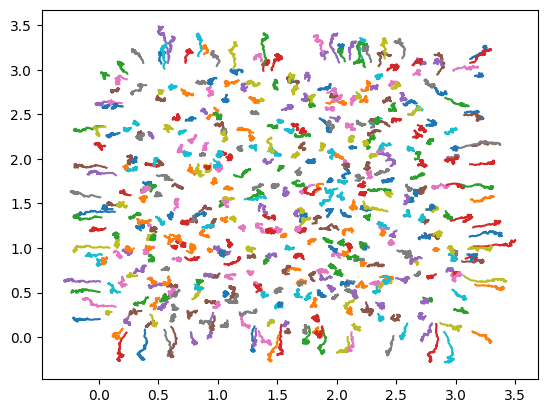

In [ ]:
plt.plot(controlled_R_list[:,:,0],controlled_R_list[:,:,1])
plt.show()

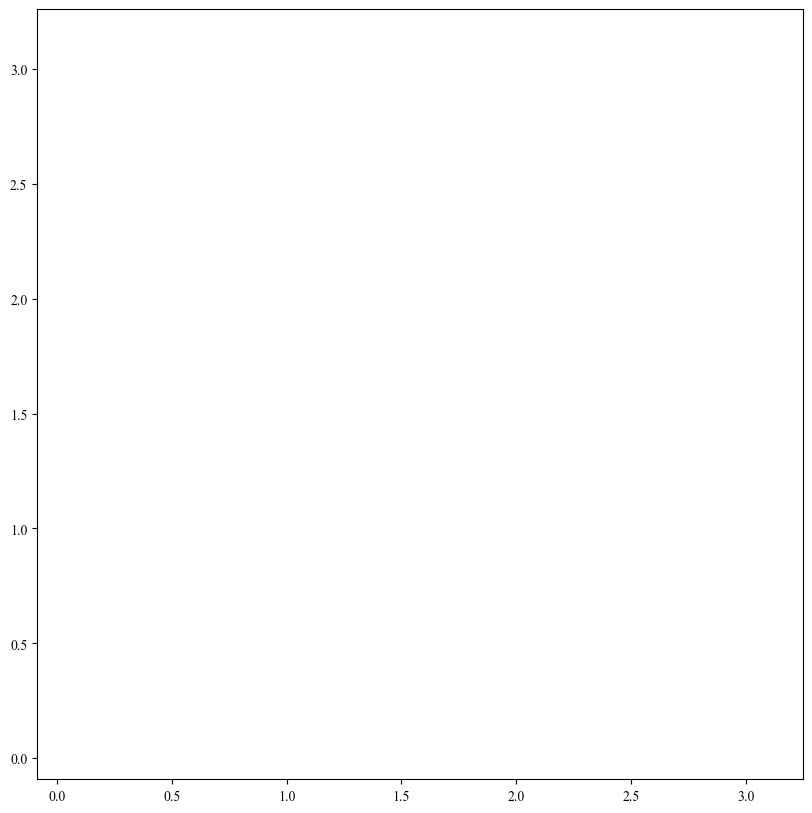

In [ ]:
fig_size = (10,10)
fig, ax = plt.subplots(figsize=fig_size)

xmin = jnp.min(R0[:,0]) - 0.1
xmax = jnp.max(R0[:,0]) + 0.1
ymin = jnp.min(R0[:,1]) - 0.1
ymax = jnp.max(R0[:,1]) + 0.1

n = 500
X, Y = jnp.mgrid[xmin:xmax:(n*1j), ymin:ymax:(n*1j)]
positions = jnp.transpose(jnp.vstack([X.ravel(), Y.ravel()]))
positions_list = jnp.reshape(positions, (n*n,1,2))

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')

In [ ]:
def animate(j):
  k = 2*j
  ax.clear()

  R = controlled_R_list[k]
  C = controlled_C_list[k]

  def C_field(x):
    metric_vmap = vmap(vmap(metric, in_axes=(None, 0)), in_axes=(0, None))
    return jnp.einsum('i,ij->j', jnp.exp(jnp.squeeze(- alpha*jnp.square(metric_vmap(x, R)))), C)
  batch_C_field = vmap(C_field)

  C_eval_euler = jnp.reshape(batch_C_field(positions_list), (n,n,3))
  # fgrnd1 = ax.pcolormesh(X, Y, C_eval_euler/jnp.max(C_eval_euler))
  fgrnd2 = ax.imshow(jnp.rot90(C_eval_euler/jnp.max(C_eval_euler)))

  return fgrnd2

ani = FuncAnimation(fig, animate, interval=50, blit=False, repeat=True, frames=int(controlled_R_list.shape[0]/2))
ani.save("RD_controlled_revised_2.gif", dpi=300, writer=PillowWriter(fps=10))

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit, vmap
from functools import partial

# Precompute the positions
n = 100  # or whatever value you're using
x = jnp.linspace(0, box_size, n)
y = jnp.linspace(0, box_size, n)
X, Y = jnp.meshgrid(x, y)
positions_list = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

# JIT-compile the C_field function
@partial(jit, static_argnums=(2,))
def C_field_jitted(R, C, alpha):
    metric_vmap = vmap(vmap(metric, in_axes=(None, 0)), in_axes=(0, None))
    distances = metric_vmap(positions_list, R)
    weights = jnp.exp(-alpha * jnp.square(distances))
    return jnp.einsum('ij,jk->ik', weights, C)

# JIT-compile the frame generation function
@jit
def generate_frame(R, C, alpha):
    C_eval_euler = C_field_jitted(R, C, alpha)
    C_eval_euler = C_eval_euler.reshape(n, n, 3)
    return C_eval_euler / jnp.max(C_eval_euler)

# Precompute all frames
@jit
def precompute_frames(R_list, C_list, alpha):
    return vmap(generate_frame, in_axes=(0, 0, None))(R_list, C_list, alpha)

# Precompute all frames
all_frames = precompute_frames(controlled_R_list, controlled_C_list, alpha)

# Convert to numpy for matplotlib
all_frames_np = jnp.array(all_frames)

def animate(j):
    ax.clear()
    frame = all_frames_np[j]
    fgrnd1 = ax.pcolormesh(X, Y, frame)
    rotated_frame = jnp.rot90(frame, k=-1)
    fgrnd2 = ax.imshow(rotated_frame, origin='lower')
    return fgrnd2

ani = FuncAnimation(fig, animate, interval=50, blit=False, repeat=True, frames=int(controlled_R_list.shape[0]))
ani.save("RD_controlled_revised.gif", dpi=300, writer=PillowWriter(fps=10))

NameError: name 'np' is not defined

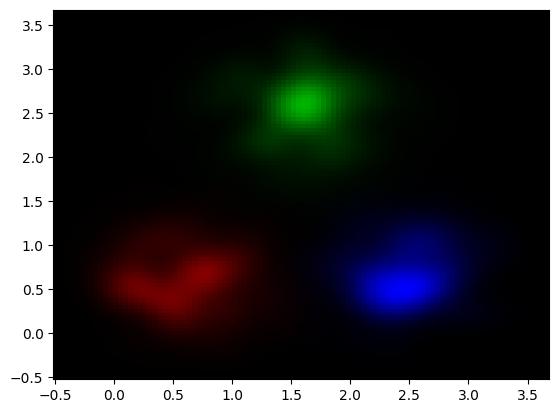

In [ ]:
k=1

def C_field(x):
    metric_vmap = vmap(vmap(metric, in_axes=(None, 0)), in_axes=(0, None))
    return jnp.einsum('i,ij->j', jnp.exp(jnp.squeeze(- alpha*jnp.square(metric_vmap(x, controlled_R_list[k])))), controlled_C_list[k])

batch_C_field = vmap(C_field)

C_field_euler = jnp.reshape(batch_C_field(positions_list), (n,n,3))
plt.pcolormesh(X, Y, C_field_euler/jnp.max(C_field_euler))

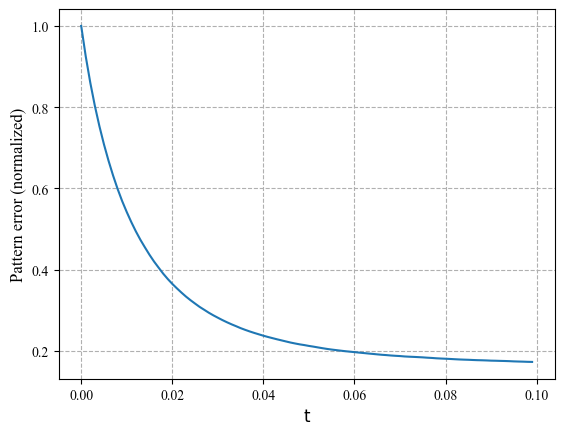

In [ ]:
err = []

for i in range(controlled_R_list.shape[0]):
  err.append(jnp.sqrt(terminal_cost(controlled_R_list[i], controlled_C_list[i])))

err = jnp.array(err)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.plot(0.001*jnp.arange(err.shape[0]), err/jnp.max(err))
plt.xlabel(r'$\mathrm{t}$', fontsize=12)
plt.ylabel(r'Pattern error (normalized)', fontsize=12)
plt.grid(linestyle='--')
plt.savefig('pattern_error' + '.pdf', bbox_inches='tight')

In [ ]:
import jax.numpy as jnp
from jax import jit, vmap

@jit
def C_target(pos):
    # Define the dimensions of the H
    vertical_bar_width = box_size / 8
    horizontal_bar_height = box_size / 8
    h_height = box_size * 3 / 4

    # Define the positions of the H components
    left_x = box_size * 5 / 16
    right_x = box_size * 11 / 16
    top_y = box_size * 7 / 8
    bottom_y = box_size / 8
    middle_y = box_size / 2

    # Check if the position is within the left vertical bar (red)
    left_bar = (pos[0] >= left_x - vertical_bar_width/2) & (pos[0] <= left_x + vertical_bar_width/2) & \
               (pos[1] >= bottom_y) & (pos[1] <= top_y)

    # Check if the position is within the right vertical bar (blue)
    right_bar = (pos[0] >= right_x - vertical_bar_width/2) & (pos[0] <= right_x + vertical_bar_width/2) & \
                (pos[1] >= bottom_y) & (pos[1] <= top_y)

    # Check if the position is within the horizontal bar (green)
    horiz_bar = (pos[0] >= left_x + vertical_bar_width/2) & (pos[0] <= right_x - vertical_bar_width/2) & \
                (pos[1] >= middle_y - horizontal_bar_height/2) & (pos[1] <= middle_y + horizontal_bar_height/2)

    # Add some smoothing to the edges
    sigma = box_size / 100  # Adjust this value to change the amount of smoothing
    red = jnp.exp(-((pos[0] - left_x)**2 + (pos[1] - middle_y)**2) / (2*sigma**2)) * left_bar
    green = jnp.exp(-((pos[0] - (left_x + right_x)/2)**2 + (pos[1] - middle_y)**2) / (2*sigma**2)) * horiz_bar
    blue = jnp.exp(-((pos[0] - right_x)**2 + (pos[1] - middle_y)**2) / (2*sigma**2)) * right_bar

    # Normalize colors to ensure they sum to 1 at each point
    total = red + green + blue
    red, green, blue = red / total, green / total, blue / total

    return jnp.array([red, green, blue])

batch_C_target = jit(vmap(C_target))


import matplotlib.pyplot as plt

n = 100
x = jnp.linspace(0, box_size, n)
y = jnp.linspace(0, box_size, n)
X, Y = jnp.meshgrid(x, y)
positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

C_target_eval = batch_C_target(positions)
C_target_image = C_target_eval.reshape(n, n, 3)

# plt.figure(figsize=(8, 8))
# plt.imshow(C_target_image)
# plt.axis('off')
# plt.title('H-shaped Target Field')
# plt.show()